# Code to get marine species, threats, and trends from the IUCN API

In [ ]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import pycountry
import time

from tqdm import tqdm
from sklearn.linear_model import LinearRegression

# Define the base URL and your API token
base_url = "https://api.iucnredlist.org/api/v4/habitats/"
token = "" # insert your IUCN API key

# Set up the headers with the token
headers = {
    "accept": "application/json",
    "Authorization": token
}

# Function to convert country code to country name
def get_country_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return 'Unknown'

# Function to get assessments for a given habitat
def get_assessments(habitat_id):
    page = 1
    per_page = 100
    assessments = []
    
    while True:
        print(f"Habitat: {habitat_id}, Page: {page}")
        # Construct the URL with pagination parameters
        url = f"{base_url}{habitat_id}?page={page}&per_page={per_page}"
        
        # Make the GET request
        response = requests.get(url, headers=headers)
        
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            assessments.extend(data.get('assessments', []))
            
            # Check if we have reached the last page
            total_pages = int(response.headers.get('total-pages', 1))
            if page >= total_pages:
                break
            
            # Move to the next page
            page += 1
        else:
            print(f"Failed to retrieve data for habitat {habitat_id}: {response.status_code} - {response.text}")
            break
            
    return assessments

In [ ]:
# Get marine assessments

if not os.path.exists("../Data/marine_habitats.csv"):
    # Initialize variables for storing all assessments
    all_assessments = []
    
    # Iterate through major categories and their subcategories
    major_habitats = [9, 10, 11, 12, 13]
    for habitat_id in major_habitats:
        # Get assessments for the main category
        all_assessments.extend(get_assessments(habitat_id))
        
        # Check for subcategories (assuming subcategories range from 1 to 15)
        for sub_id in range(1, 16):
            sub_habitat_id = f"{habitat_id}_{sub_id}"
            all_assessments.extend(get_assessments(sub_habitat_id))
    
    # Extract relevant information for each assessment
    rows = []
    for assessment in all_assessments:
        row = {
            "year_published": assessment.get("year_published"),
            "latest": assessment.get("latest"),
            "sis_taxon_id": assessment.get("sis_taxon_id"),
            "url": assessment.get("url"),
            "assessment_id": assessment.get("assessment_id"),
            "code": assessment.get("code"),
            "code_type": assessment.get("code_type"),
            "scope_description": assessment.get("scopes")[0].get("description").get("en") if assessment.get("scopes") else None,
            "scope_code": assessment.get("scopes")[0].get("code") if assessment.get("scopes") else None,
            "habitat_id": assessment.get("habitat_id"),  # Add habitat_id to the row
        }
        rows.append(row)
    
    # Create a DataFrame
    marine_df = pd.DataFrame(rows)
    marine_df.to_csv("../Data/marine_habitats.csv")
    marine_df
else:
    marine_df = pd.read_csv("../Data/marine_habitats.csv")
    marine_df

In [ ]:
base_url = "https://api.iucnredlist.org/api/v4/assessment"

# Assuming df_combined is defined elsewhere in your code
assessements_list = marine_df.loc[marine_df.groupby('sis_taxon_id')['year_published'].idxmax()].reset_index(drop=True)

# List of assessment IDs
assessment_ids = assessements_list['assessment_id'].dropna().astype(int).values

# Initialize empty lists to hold all the data if not already defined
try:
    all_data
except NameError:
    all_data = []

try:
    all_data_threats
except NameError:
    all_data_threats = []

# Extract processed assessment_ids from all_data
processed_assessment_ids = {entry["assessment_id"] for entry in all_data}

def fetch_data_with_retry(url, headers, retries=5, backoff_factor=0.5):
    for i in range(retries):
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            wait_time = backoff_factor * (2 ** i)
            print(f"Rate limit exceeded. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print(f"Failed to retrieve data: {response.status_code} - {response.text}")
            break
    return None

if not os.path.exists("../Data/all_threats_species.csv"):
    for assessment_id in tqdm(assessment_ids):
        # Skip if the assessment_id is already processed
        if assessment_id in processed_assessment_ids:
            continue
    
        # Construct the URL for the current assessment ID
        url = f"{base_url}/{assessment_id}"
        
        # Fetch the data with retry mechanism
        data = fetch_data_with_retry(url, headers)
        
        if data:
            trend = data.get("population_trend") if data.get("population_trend") is None else data.get("population_trend").get("code")
            class_name = data.get("taxon", {}).get("class_name")
            sis_taxon_id = data.get("sis_taxon_id", [])
            locations = data.get("locations", [])
            threats = data.get("threats", [])
            status = data.get("red_list_category", {}).get("code")
            year_published = data.get("year_published", [])
    
            # Extract the common English name (if available)
            common_names = data.get("taxon", {}).get("common_names", [])
            english_common_name = next((name['name'] for name in common_names if name['language']['code'] == 'eng'), None)
            
            # Add the assessment data to the list
            for location in locations:
                country_code = location.get("code")
                assessment_data = {
                    "assessment_id": assessment_id,
                    "sis_taxon_id": sis_taxon_id,
                    "country_code": country_code,
                    "trend": trend,
                    "class_name": class_name,
                    "status": status,
                    "year_published": year_published,
                    "english_common_name": english_common_name  # Store the common English name here
                }
                all_data.append(assessment_data)
    
            # Add the threats data to the list
            for location in locations:
                country_code = location.get("code")
                for threat in threats:
                    threat_code = threat.get("code")
                    threat_data = {
                        "assessment_id": assessment_id,
                        "sis_taxon_id": sis_taxon_id,
                        "country_code": country_code,
                        "threat_code": threat_code,
                        "class_name": class_name,
                        "year_published": year_published,
                        "english_common_name": english_common_name  # Store the common English name here
                    }
                    all_data_threats.append(threat_data)
            
            # Mark the assessment_id as processed
            processed_assessment_ids.add(assessment_id)
    
    # Create DataFrames from the collected data
    trends_df = pd.DataFrame(all_data)
    threats_df = pd.DataFrame(all_data_threats)
    trends_df.to_csv("../Data/all_trends_species.csv")
    threats_df.to_csv("../Data/all_threats_species.csv")
else:
    trends_df = pd.read_csv("../Data/all_trends_species.csv")
    threats_df = pd.read_csv("../Data/all_threats_species.csv")

## Figure 1

In [ ]:
trends_df = trends_df[["assessment_id","year_published","sis_taxon_id","country_code","status","class_name","english_common_name","trend"]]#.merge(df_unique[["assessment_id","year_published","sis_taxon_id"]], on="assessment_id", how="inner")
trends_df['year_published'] = trends_df['year_published'].astype(int)

# Mapping dictionary
threats_mapping = {
    'DD': 'Data Deficient',
    'LC': 'Least Concern',
    'NT': 'Near Threatened',
    'VU': 'Vulnerable',
    'EN': 'Endangered',
    'CR': 'Critically Endangered',
    'EW': 'Extinct in the Wild',
    'EX': 'Extinct',
    'NE': 'Not Evaluated',
}

# Replace the values in the 'Threat' column
trends_df['Threat'] = trends_df['status'].replace(threats_mapping)

trends_df.loc[trends_df["trend"] == 0, 'trend_title'] = "Increasing"
trends_df.loc[trends_df["trend"] == 1, 'trend_title'] = "Decreasing"
trends_df.loc[trends_df["trend"] == 2, 'trend_title'] = "Stable"
trends_df.loc[trends_df["trend"] == 3, 'trend_title'] = "Unknown"

# Initialize an empty list to store new rows
new_rows = []

# Define the range of years
years = range(1997, 2025)

# Iterate through each sis_taxon_id
for sis_taxon_id in tqdm(trends_df['sis_taxon_id'].unique()):
    # Filter data for the current sis_taxon_id
    df_sis = trends_df[trends_df['sis_taxon_id'] == sis_taxon_id]
    
    # Iterate through each year in the defined range
    for year in years:
        # Check if there is an entry for the current year
        if year not in df_sis['year_published'].values:
            # Find the most recent threat categorization from a previous year
            previous_threats = df_sis[df_sis['year_published'] < year]
            if not previous_threats.empty:
                last_threat = previous_threats.iloc[-1]['Threat']
                class_name = previous_threats.iloc[-1]['class_name']
                country_code = previous_threats.iloc[-1]['country_code']
                english_common_name = previous_threats.iloc[-1]['english_common_name']
                trend_title = previous_threats.iloc[-1]['trend_title']
                # Create a new row with the current year, sis_taxon_id, and the most recent threat categorization
                new_row = {
                    'year_published': year,
                    'Threat': last_threat,
                    'sis_taxon_id': sis_taxon_id,
                    'class_name': class_name,
                    "country_code": country_code,
                    "english_common_name": english_common_name,
                    "trend_title": trend_title,
                }
                new_rows.append(new_row)

# Create a DataFrame from the new rows
df_new_rows = pd.DataFrame(new_rows)

# Append the new rows to the original dataframe
df_combined = pd.concat([trends_df, df_new_rows])

# Sort the combined dataframe
df_combined = df_combined.sort_values(by=['sis_taxon_id', 'year_published']).reset_index(drop=True)

# Apply the function to the country_code column
df_combined['country_name'] = df_combined['country_code'].apply(get_country_name)

In [ ]:
# Define the mapping
class_to_category = {
    'ACTINOPTERYGII': 'Fish', 
    'CHONDRICHTHYES': 'Fish', 
    'SARCOPTERYGII': 'Fish', 
    'PETROMYZONTI': 'Fish',
    'MYXINI': 'Fish',
    'CEPHALASPIDOMORPHI': 'Fish',
    'MAMMALIA': 'Mammals', 
    'REPTILIA': 'Reptiles', 
    'AVES': 'Birds'
}

df_combined = df_combined.drop_duplicates(["sis_taxon_id","year_published"]).merge(marine_df.drop_duplicates("sis_taxon_id")[["sis_taxon_id"]],on='sis_taxon_id',how='inner')

# Map the class names to categories
df_combined['category'] = df_combined['class_name'].map(class_to_category)

# Remove rows where category is NaN (those not in the specified classes)
df_combined = df_combined.dropna(subset=['category'])

# Create a pivot table for the total counts of species across all years and categories
pivot_total = df_combined.pivot_table(index='year_published', columns='category', aggfunc='size', fill_value=0)

# Filter the data for specific threats
filtered_df = df_combined[df_combined['Threat'].isin(['Critically Endangered', 'Endangered', 'EW', 'EX'])]

# Create a pivot table for the filtered (threatened) species
pivot_filtered = filtered_df.pivot_table(index='year_published', columns='category', aggfunc='size', fill_value=0)

In [ ]:
pivot_filtered['All'] = (pivot_filtered["Birds"] + pivot_filtered["Fish"] + pivot_filtered["Mammals"] + pivot_filtered["Reptiles"])
pivot_total['All'] = (pivot_total["Birds"] + pivot_total["Fish"] + pivot_total["Mammals"] + pivot_total["Reptiles"])

pivot_percent = (pivot_filtered / pivot_total)
protect_marine_life_df = pivot_percent.reset_index()
X_years=protect_marine_life_df["year_published"].values.reshape([-1,1])
y_percents=(pivot_filtered["Birds"] + pivot_filtered["Fish"] + pivot_filtered["Mammals"] + pivot_filtered["Reptiles"]).values/\
    (pivot_total["Birds"] + pivot_total["Fish"] + pivot_total["Mammals"] + pivot_total["Reptiles"]).values
y_counts = (pivot_total["Birds"] + pivot_total["Fish"] + pivot_total["Mammals"] + pivot_total["Reptiles"]).values

In [ ]:
# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_years, y_percents, sample_weight=y_counts)

# Predict the linear trend based on the years
protect_marine_life_df['Linear Trend'] = linear_model.predict(X_years)

protect_marine_life_df.fillna(0).to_csv("../Data/protect_marine_life_1.csv")

# Display the updated DataFrame with the linear trend
protect_marine_life_df.fillna(0)

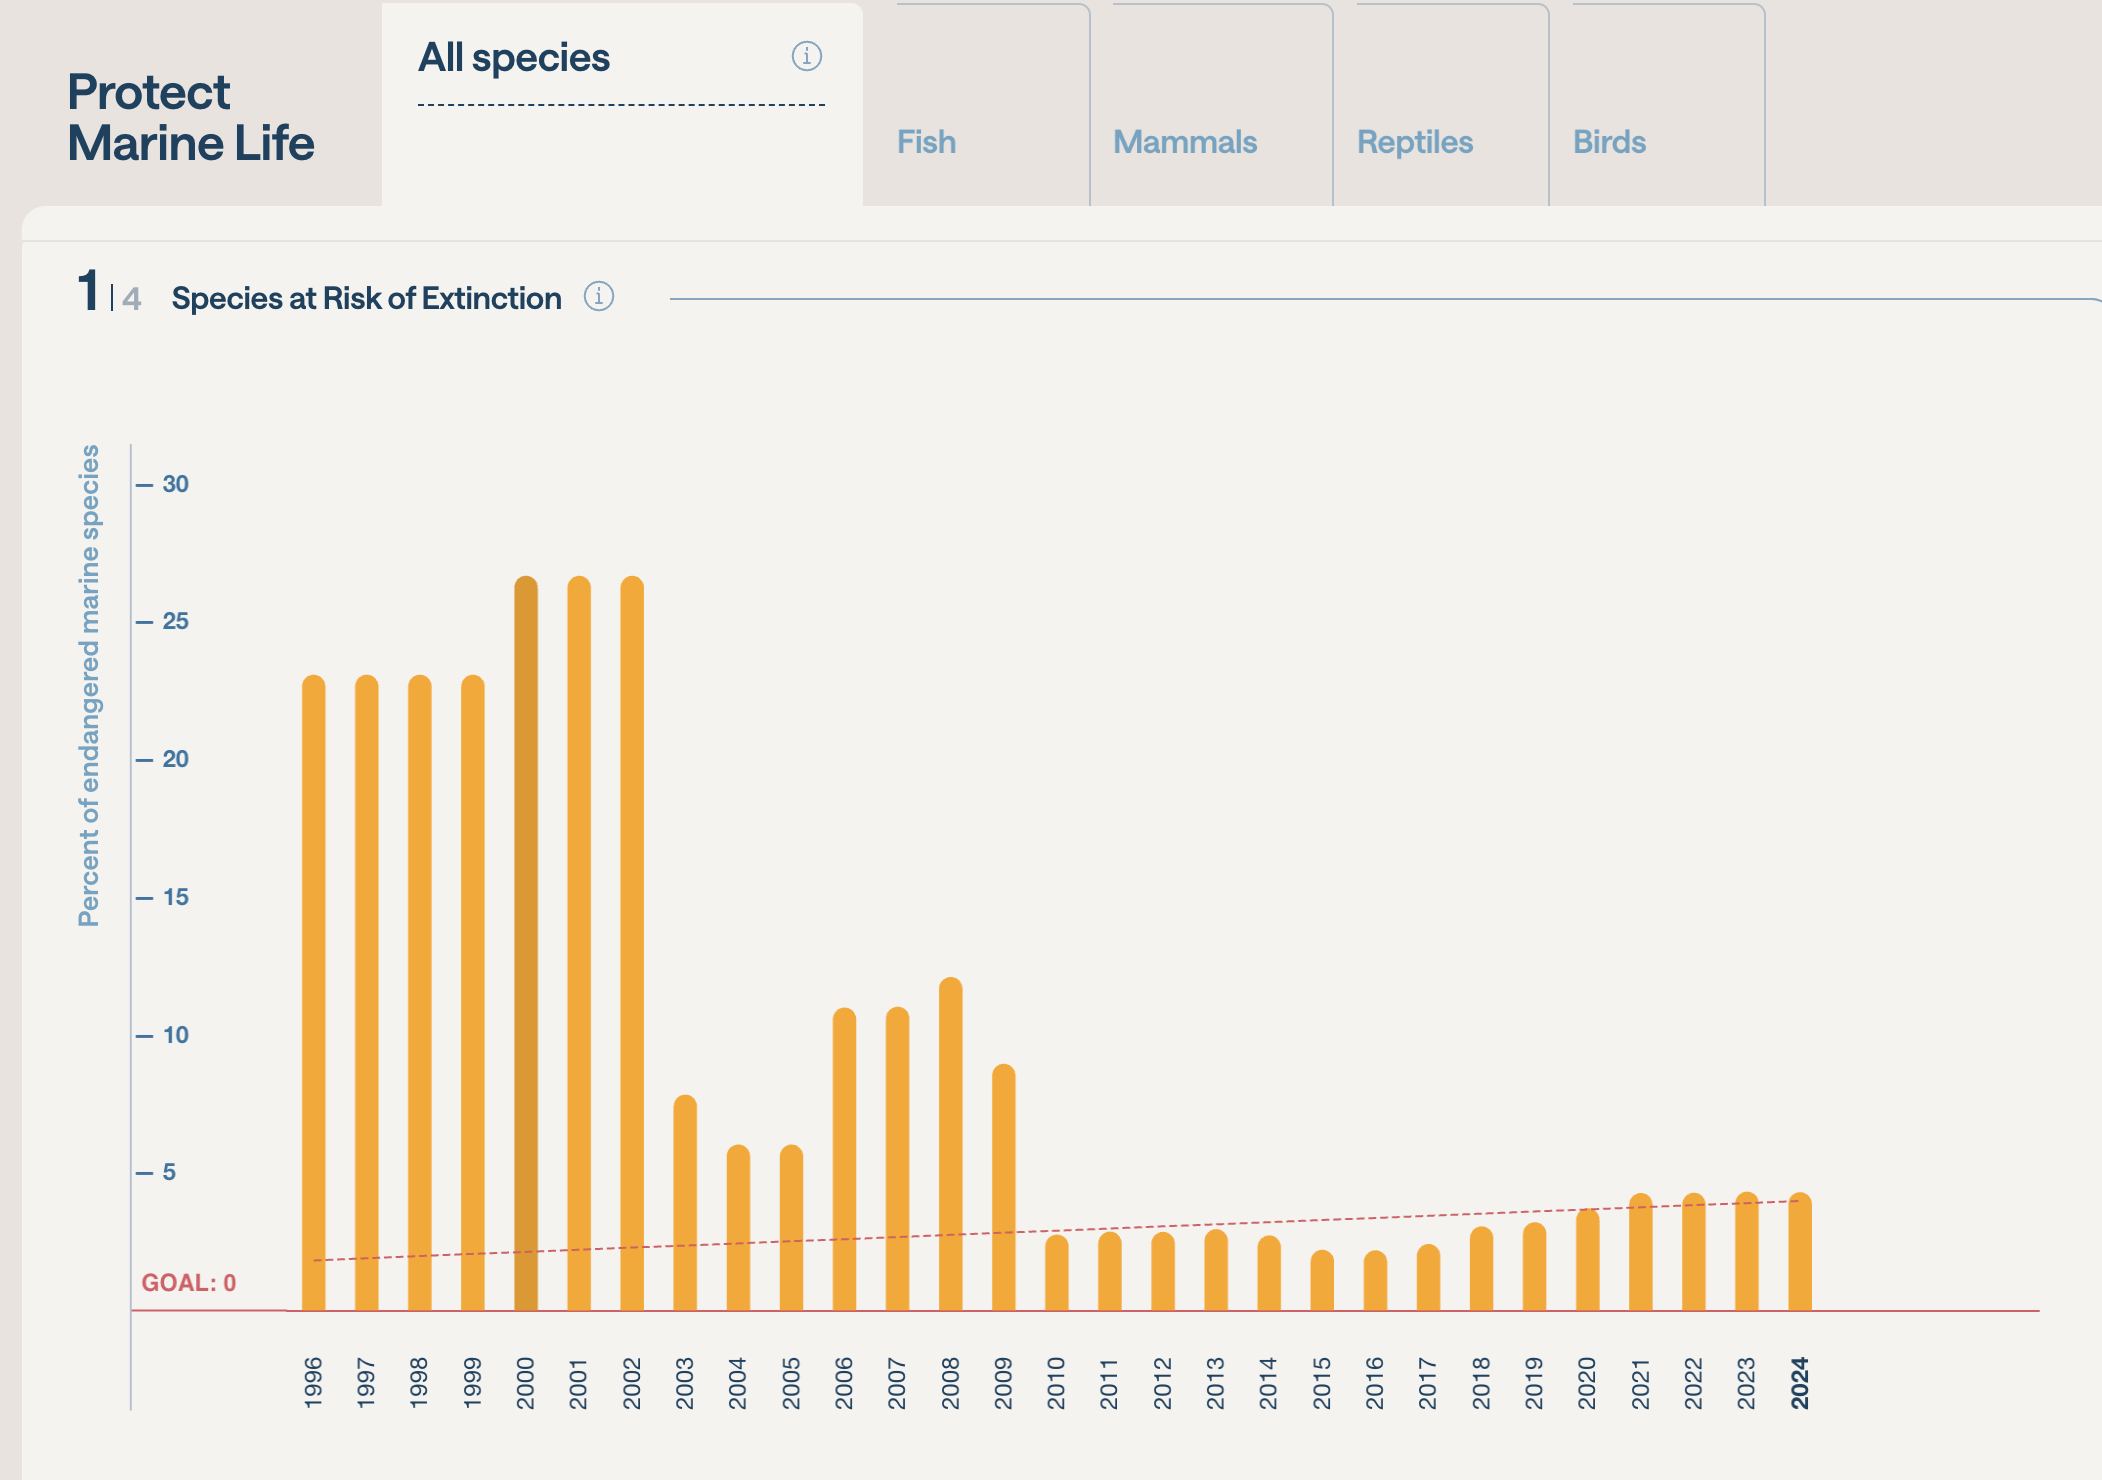

## Fig 2

In [ ]:
trends_df = pd.read_csv("all_country_trends.csv")

joint_df = df_combined.drop_duplicates("assessment_id")[['sis_taxon_id','assessment_id','category']].merge(trends_df[['assessment_id','trend_title','country_name','country_code']],on=['assessment_id'])
joint_df = joint_df.merge(marine_df.drop_duplicates("sis_taxon_id")[["sis_taxon_id"]],on='sis_taxon_id',how='inner')
joint_df.to_csv("../Data/protect_marine_life_2.csv")

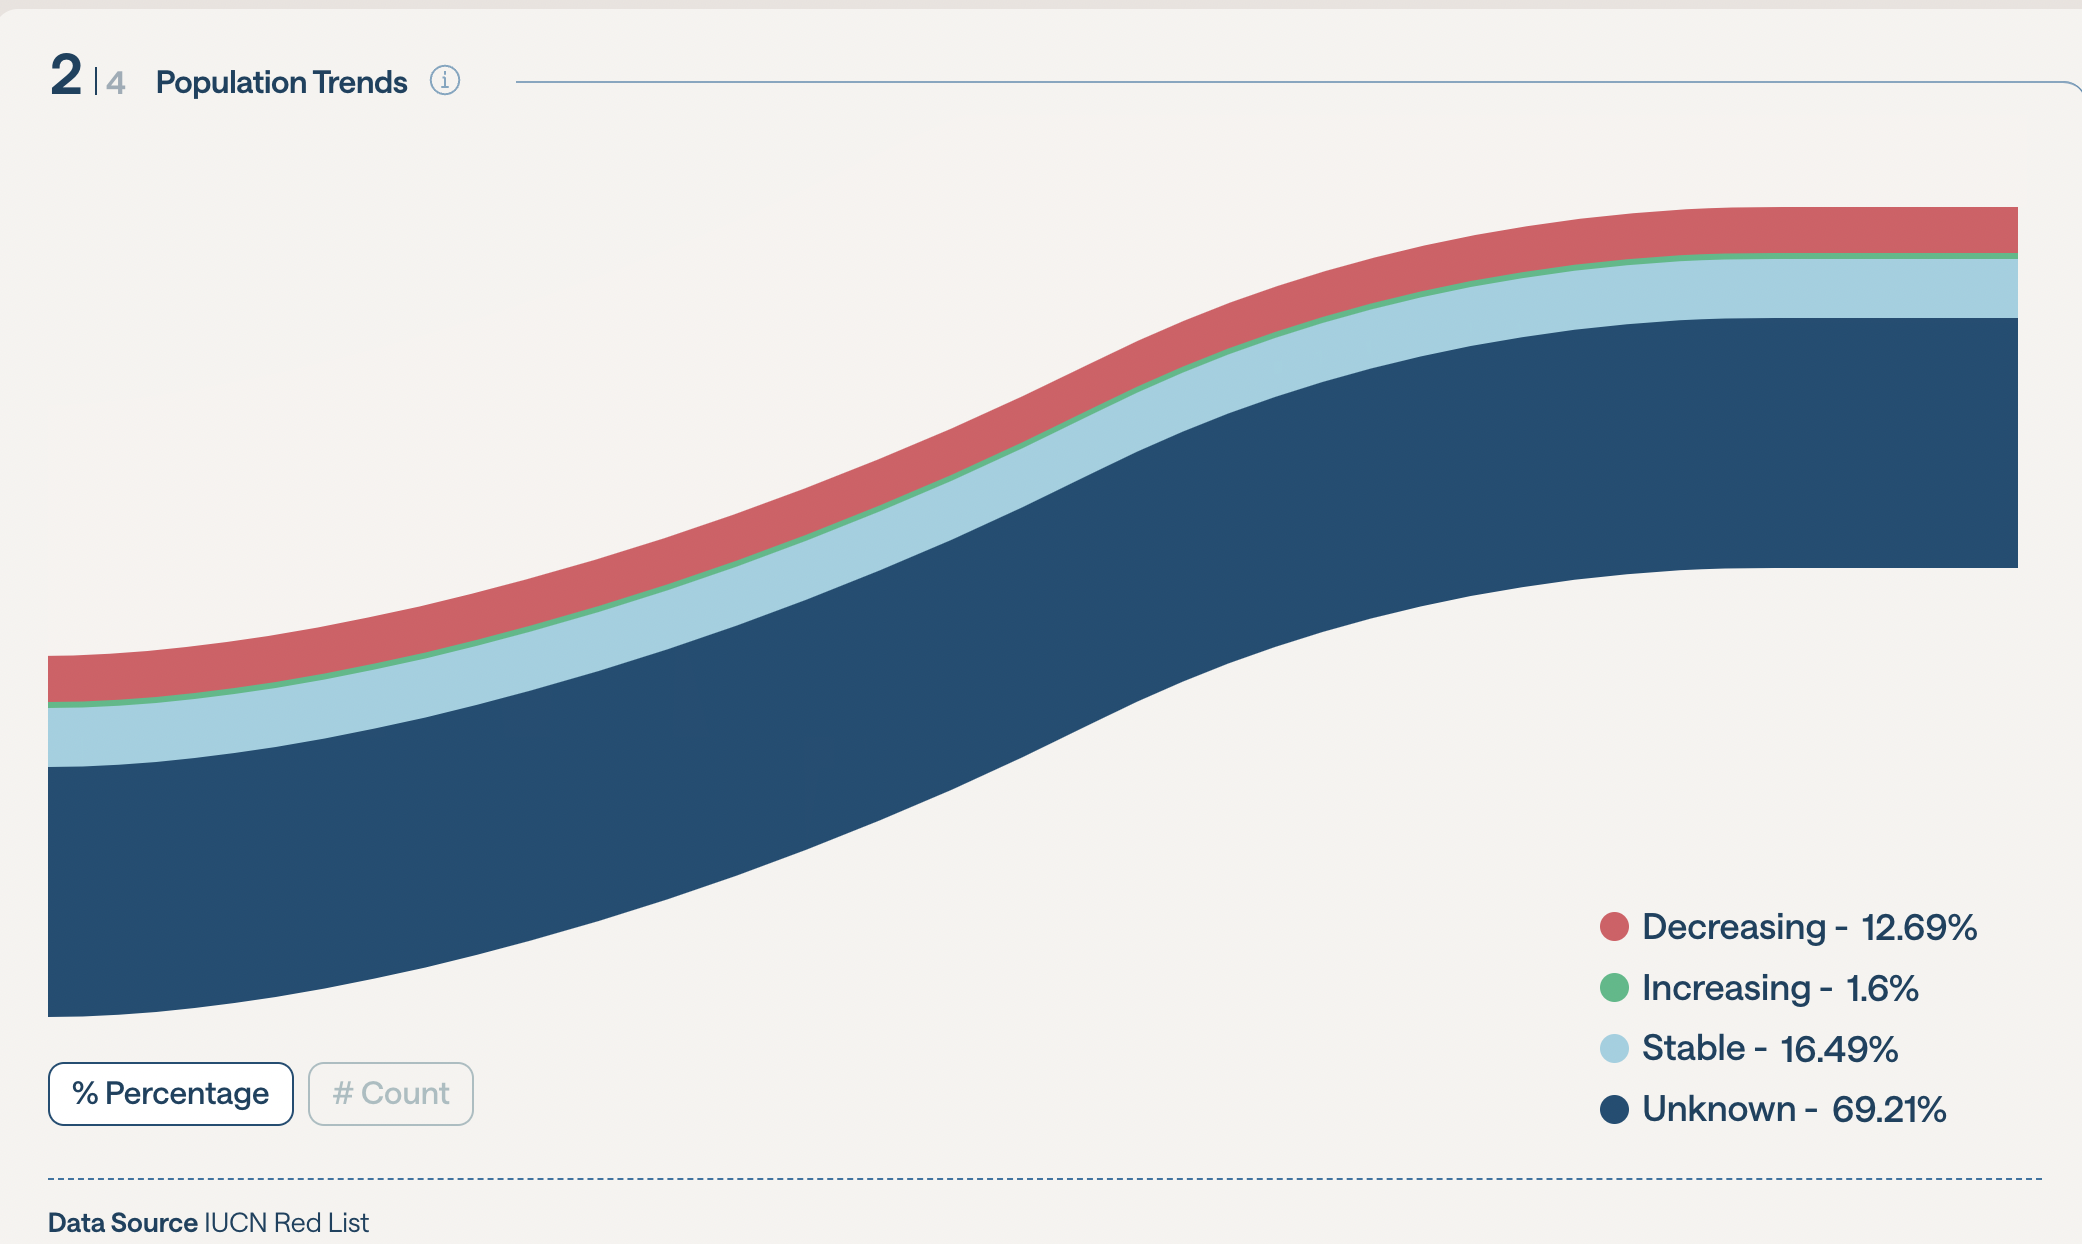

## Fig 3

In [ ]:
# Define a function to map threat_code to Threat
def map_threat(threat_code):
    if threat_code.startswith('1_'):
        return 'Residential & commercial development'
    elif threat_code.startswith('2_'):
        return 'Agriculture & aquaculture'
    elif threat_code.startswith('3'):
        return 'Energy production & mining'
    elif threat_code.startswith('4_'):
        return 'Transportation & service corridors'
    elif threat_code.startswith('5_'):
        return 'Biological resource use'
    elif threat_code.startswith('6'):
        return 'Human intrusions & disturbance'
    elif threat_code.startswith('7_'):
        return 'Natural system modifications'
    elif threat_code.startswith('8_'):
        return 'Invasive and other problematic species, genes & diseases'
    elif threat_code.startswith('9_'):
        return 'Pollution'
    elif threat_code.startswith('10_'):
        return 'Geological events'
    elif threat_code.startswith('11_'):
        return 'Climate change & severe weather'
    elif threat_code.startswith('12_'):
        return 'Other'
    else:
        return 'Unknown'  # for any other threat codes

threats_df = pd.read_csv("../Data/all_threats_species.csv")

# Apply the function to create the new Threat column
threats_df['Threat'] = threats_df['threat_code'].apply(map_threat)

# Apply the function to the country_code column
threats_df['country_name'] = threats_df['country_code'].apply(get_country_name)

joint_df = df_combined.drop_duplicates("assessment_id")[['sis_taxon_id','assessment_id','category']].merge(threats_df[['assessment_id','Threat','country_name','country_code']],on='assessment_id')
joint_df = joint_df.merge(marine_df.drop_duplicates("sis_taxon_id")[["sis_taxon_id"]],on='sis_taxon_id',how='inner')
joint_df.query("country_name!='Unknown'").to_csv("../Data/protect_marine_life_3.csv")

joint_df.query("country_name!='Unknown'")

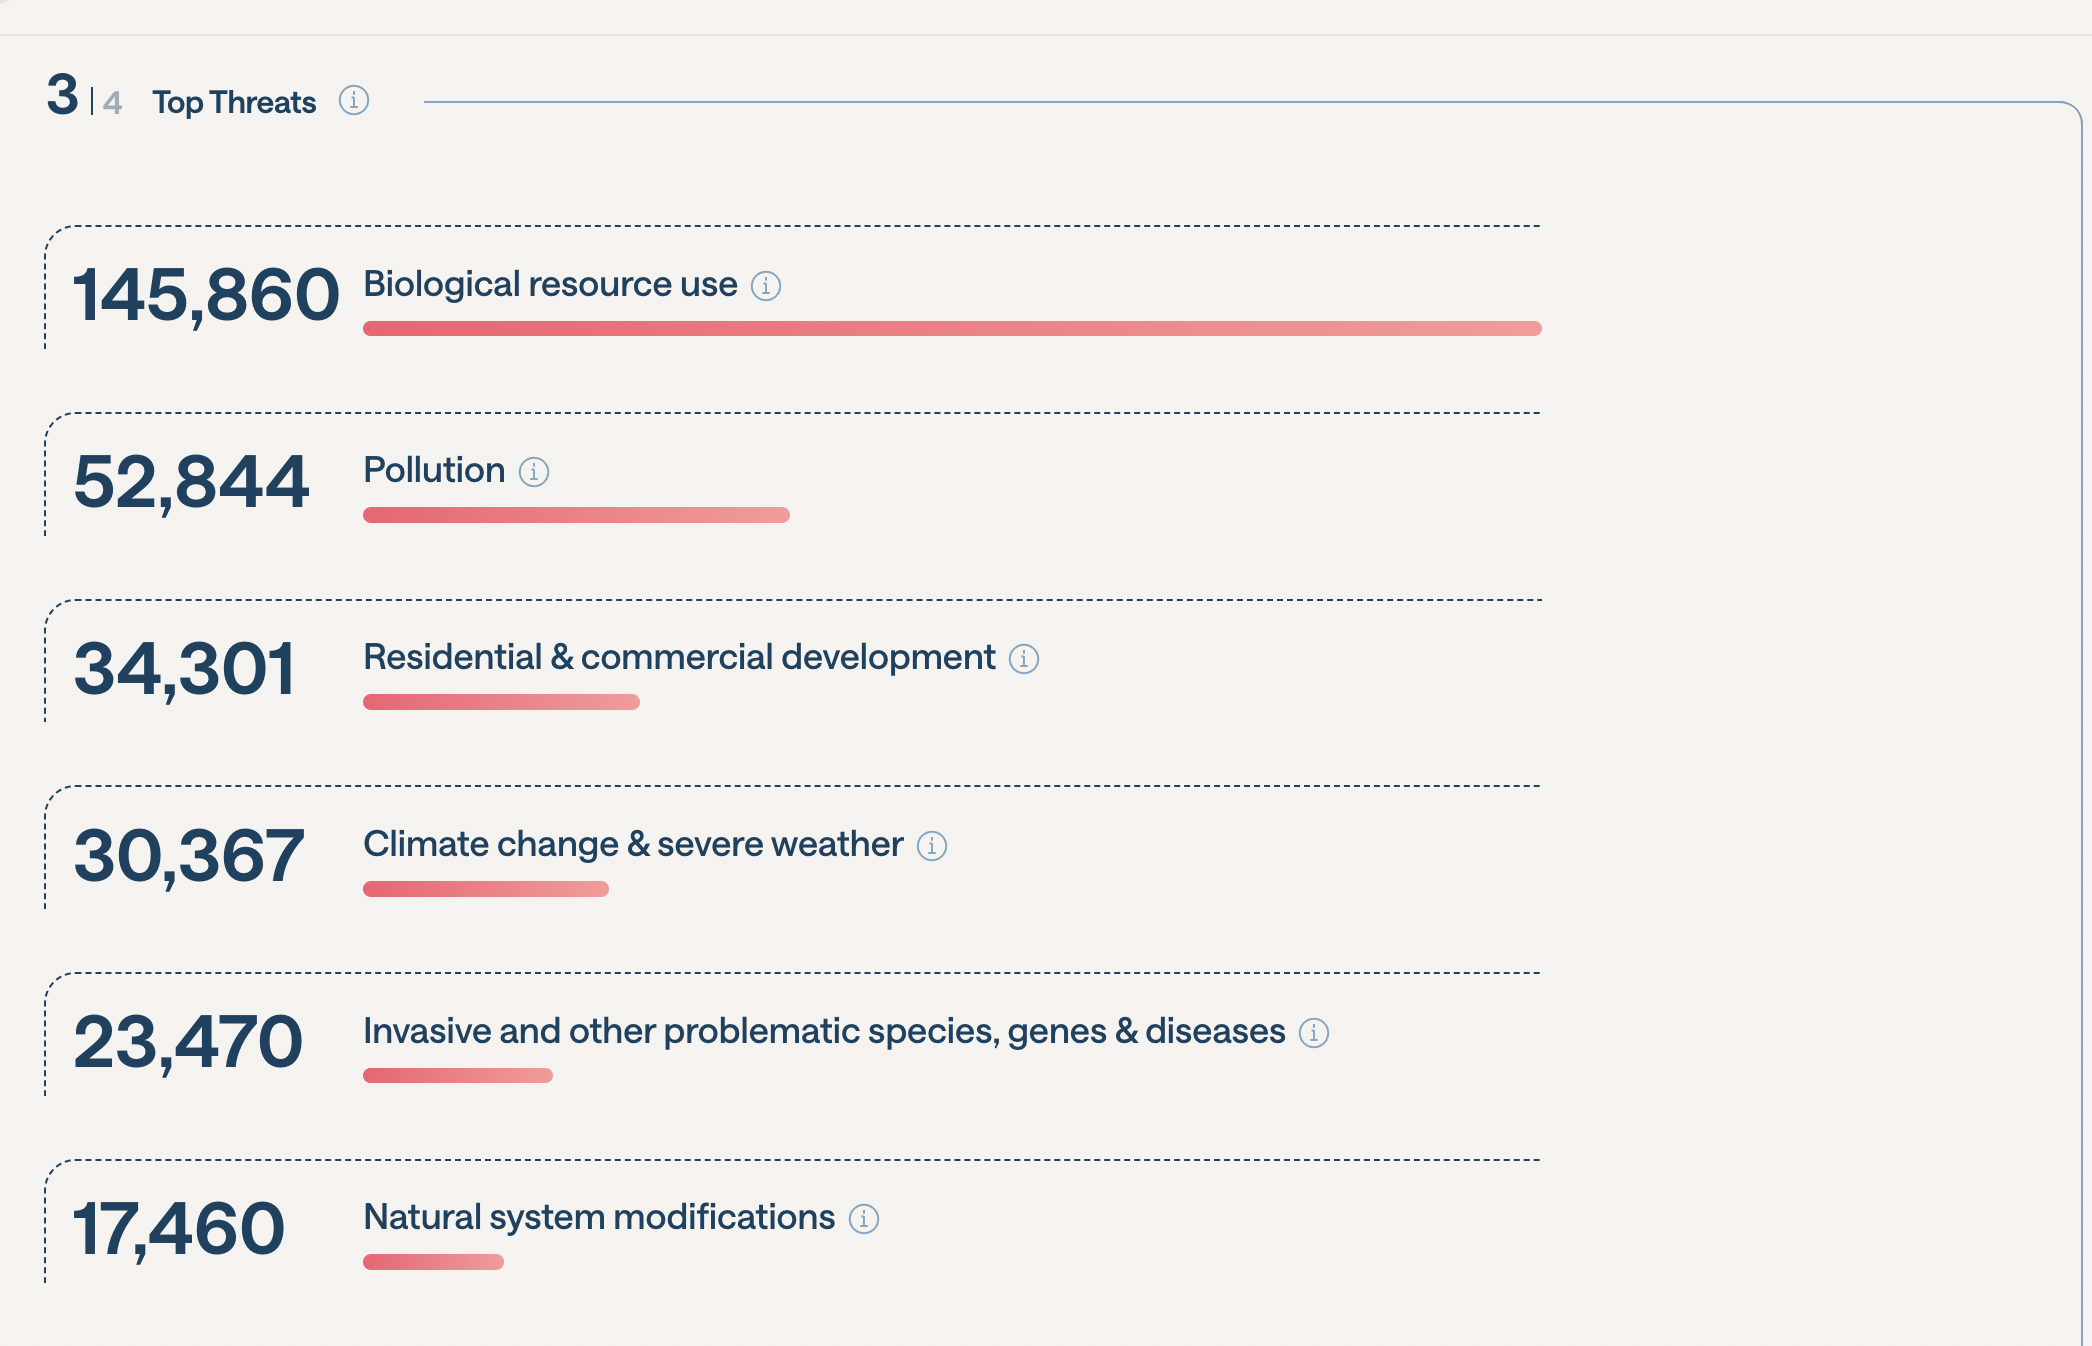

## Fig 4

In [ ]:
from tqdm import tqdm
import pandas as pd

threats_df = pd.read_csv("../Data/all_threats_species.csv")
threats_df = threats_df[["assessment_id","sis_taxon_id","year_published","country_code","threat_code","class_name","english_common_name"]]
# Initialize an empty list to store new rows
new_rows = []

# Define the range of years
years = range(1997, 2025)

# Iterate through each sis_taxon_id
for sis_taxon_id in tqdm(threats_df['sis_taxon_id'].unique()):
    # Filter data for the current sis_taxon_id
    df_sis = threats_df[threats_df['sis_taxon_id'] == sis_taxon_id]
    
    # Iterate through each year in the defined range
    for year in years:
        # Check if there is an entry for the current year
        if year not in df_sis['year_published'].values:
            # Find the most recent threat categorization from a previous year
            previous_threats = df_sis[df_sis['year_published'] < year]
            if not previous_threats.empty:
                last_threat = previous_threats.iloc[-1]['threat_code']
                class_name = previous_threats.iloc[-1]['class_name']
                english_common_name = previous_threats.iloc[-1]['english_common_name']
                country_code = previous_threats.iloc[-1]['country_code']
                # Create a new row with the current year, sis_taxon_id, and the most recent threat categorization
                new_row = {
                    'year_published': year,
                    'threat_code': last_threat,
                    'sis_taxon_id': sis_taxon_id,
                    'class_name': class_name,
                    'english_common_name': english_common_name,
                    "country_code": country_code
                }
                new_rows.append(new_row)

# Create a DataFrame from the new rows
df_new_rows = pd.DataFrame(new_rows)

# Append the new rows to the original dataframe
df_combined = pd.concat([threats_df, df_new_rows])

# Apply the function to create the new Threat column
df_combined['threat_type'] = df_combined['threat_code'].apply(map_threat)

# Sort the combined dataframe
df_combined = df_combined.sort_values(by=['sis_taxon_id', 'year_published']).reset_index(drop=True)

# Apply the function to the country_code column
df_combined['country_name'] = df_combined['country_code'].apply(get_country_name)

In [ ]:
filtered_fig_4 = df_combined[(df_combined['year_published'] == 2024) & ~(df_combined['country_code'].astype(str).str.contains('-'))].merge(marine_df.drop_duplicates("sis_taxon_id")[["sis_taxon_id"]],on='sis_taxon_id',how='inner')

# Define the mapping
class_to_category = {
    'ACTINOPTERYGII': 'Fish', 
    'CHONDRICHTHYES': 'Fish', 
    'SARCOPTERYGII': 'Fish', 
    'PETROMYZONTI': 'Fish',
    'MYXINI': 'Fish',
    'CEPHALASPIDOMORPHI': 'Fish',
    'MAMMALIA': 'Mammals', 
    'REPTILIA': 'Reptiles', 
    'AVES': 'Birds'
}

# Map the class names to categories
filtered_fig_4['category'] = filtered_fig_4['class_name'].map(class_to_category)

# Remove rows where category is NaN (those not in the specified classes)
filtered_fig_4 = filtered_fig_4.dropna(subset=['category', 'english_common_name']).query("country_name != 'Unknown'")

filtered_fig_4[['category','country_name','country_code','english_common_name','threat_type']].dropna().drop_duplicates().to_csv("../Data/protect_marine_life_4_threats.csv")

In [ ]:
from tqdm import tqdm

trends_df = pd.read_csv("../Data/all_trends_species.csv")
trends_df = trends_df[["assessment_id","sis_taxon_id","year_published","country_code","status","class_name","english_common_name","trend"]]

# Mapping dictionary
threats_mapping = {
    'DD': 'Data Deficient',
    'LC': 'Least Concern',
    'NT': 'Near Threatened',
    'VU': 'Vulnerable',
    'EN': 'Endangered',
    'CR': 'Critically Endangered',
    'EW': 'Extinct in the Wild',
    'EX': 'Extinct',
    'NE': 'Not Evaluated',
}

# Replace the values in the 'Threat' column
trends_df['Threat'] = trends_df['status'].replace(threats_mapping)

trends_df.loc[trends_df["trend"] == 0, 'trend_title'] = "Increasing"
trends_df.loc[trends_df["trend"] == 1, 'trend_title'] = "Decreasing"
trends_df.loc[trends_df["trend"] == 2, 'trend_title'] = "Stable"
trends_df.loc[trends_df["trend"] == 3, 'trend_title'] = "Unknown"

# Initialize an empty list to store new rows
new_rows = []

# Define the range of years
years = range(1997, 2025)

# Iterate through each sis_taxon_id
for sis_taxon_id in tqdm(trends_df['sis_taxon_id'].unique()):
    # Filter data for the current sis_taxon_id
    df_sis = trends_df[trends_df['sis_taxon_id'] == sis_taxon_id]
    
    # Iterate through each year in the defined range
    for year in years:
        # Check if there is an entry for the current year
        if year not in df_sis['year_published'].values:
            # Find the most recent threat categorization from a previous year
            previous_threats = df_sis[df_sis['year_published'] < year]
            if not previous_threats.empty:
                last_threat = previous_threats.iloc[-1]['Threat']
                class_name = previous_threats.iloc[-1]['class_name']
                country_code = previous_threats.iloc[-1]['country_code']
                english_common_name = previous_threats.iloc[-1]['english_common_name']
                trend_title = previous_threats.iloc[-1]['trend_title']
                # Create a new row with the current year, sis_taxon_id, and the most recent threat categorization
                new_row = {
                    'year_published': year,
                    'Threat': last_threat,
                    'sis_taxon_id': sis_taxon_id,
                    'class_name': class_name,
                    "country_code": country_code,
                    "english_common_name": english_common_name,
                    "trend_title": trend_title,
                }
                new_rows.append(new_row)

# Create a DataFrame from the new rows
df_new_rows = pd.DataFrame(new_rows)

# Append the new rows to the original dataframe
df_combined = pd.concat([trends_df, df_new_rows])

# Sort the combined dataframe
df_combined = df_combined.sort_values(by=['sis_taxon_id', 'year_published']).reset_index(drop=True)

# Apply the function to the country_code column
df_combined['country_name'] = df_combined['country_code'].apply(get_country_name)

In [ ]:
filtered_fig_4 = df_combined[(df_combined['year_published'] == 2024) & ~(df_combined['country_code'].astype(str).str.contains('-'))].merge(marine_df.drop_duplicates("sis_taxon_id")[["sis_taxon_id"]],on='sis_taxon_id',how='inner')

# Define the mapping
class_to_category = {
    'ACTINOPTERYGII': 'Fish', 
    'CHONDRICHTHYES': 'Fish', 
    'SARCOPTERYGII': 'Fish', 
    'PETROMYZONTI': 'Fish',
    'MYXINI': 'Fish',
    'CEPHALASPIDOMORPHI': 'Fish',
    'MAMMALIA': 'Mammals', 
    'REPTILIA': 'Reptiles', 
    'AVES': 'Birds'
}

# Map the class names to categories
filtered_fig_4['category'] = filtered_fig_4['class_name'].map(class_to_category)

# Remove rows where category is NaN (those not in the specified classes)
filtered_fig_4 = filtered_fig_4.dropna(subset=['category', 'english_common_name']).query("country_name != 'Unknown'")

filtered_fig_4[['category','country_name','country_code','english_common_name','Threat','trend_title']].dropna().to_csv("../Data/protect_marine_life_4_trends.csv")

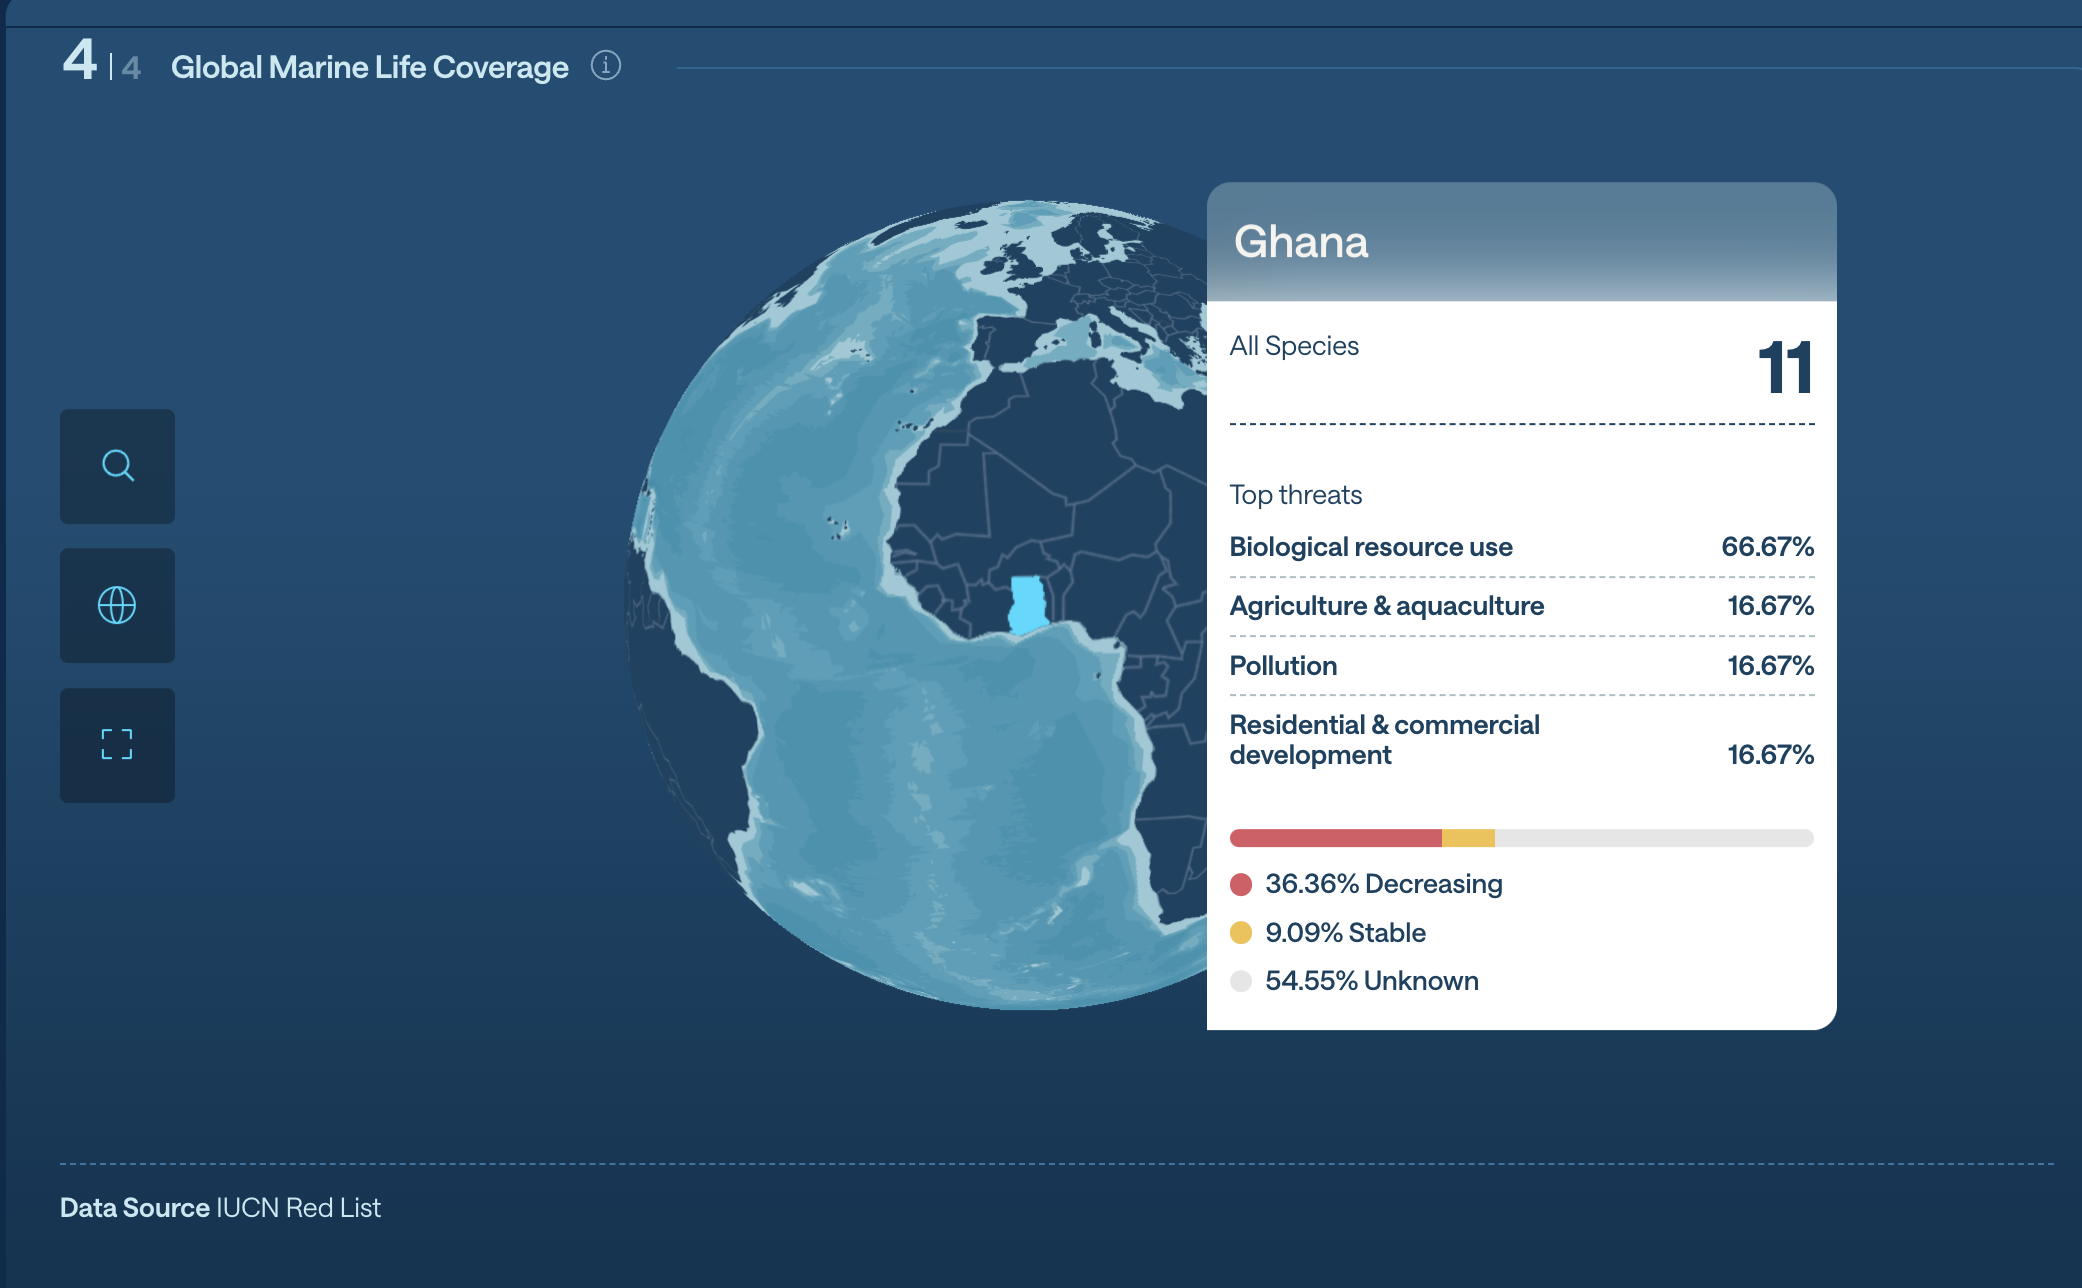